<a href="https://colab.research.google.com/github/Mayan-create/disease-suggestion./blob/main/disease_suggestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
#Load data
df = pd.read_csv("DiseaseAndSymptoms.csv")

# Disease column name
disease_col = "diseases"

# Symptom columns = all columns except disease
symptom_cols = [c for c in df.columns if c != disease_col]

print("Total symptoms:", len(symptom_cols))

# Function to extract symptoms with value=1
def extract_symptoms(row):
    symptoms = []
    for col in symptom_cols:
        if row[col] == 1:       # symptom present
            symptoms.append(col)
    return ', '.join(symptoms)

# Build training examples
examples = []
for _, row in df.iterrows():
    symptoms = extract_symptoms(row)
    disease = row[disease_col]

    # Skip if no symptoms
    if symptoms.strip() == "":
        continue

    examples.append({
        "instruction": "Identify the disease pattern based on symptoms.",
        "input": symptoms.lower(),
        "output": (
            f"Disease: {disease}\n"
            f"Explanation: These symptoms commonly match {disease} patterns in the dataset.\n"
            f"Note: This is not medical or diagnostic advice."
        )
    })

print("Total examples created:", len(examples))

Total symptoms: 377
Total examples created: 67871


In [3]:
#Train/Test Split + JSONL Save
# Train-test split
train, test = train_test_split(examples, test_size=0.2, random_state=42)

# Save train.jsonl
with open("train.jsonl", "w", encoding="utf-8") as f:
    for ex in train:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

# Save test.jsonl
with open("test.jsonl", "w", encoding="utf-8") as f:
    for ex in test:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

print("Train:", len(train))
print("Test:", len(test))


Train: 54296
Test: 13575


In [4]:
#Verify JSONL example
print(open("train.jsonl").read().splitlines()[:5])


['{"instruction": "Identify the disease pattern based on symptoms.", "input": "retention of urine, sharp abdominal pain, blood in urine, skin growth, back pain, low back pain, side pain", "output": "Disease: polycystic kidney disease\\nExplanation: These symptoms commonly match polycystic kidney disease patterns in the dataset.\\nNote: This is not medical or diagnostic advice."}', '{"instruction": "Identify the disease pattern based on symptoms.", "input": "groin mass, symptoms of the scrotum and testes, swelling of scrotum, pain in testicles, mass in scrotum, lower abdominal pain", "output": "Disease: hydrocele of the testicle\\nExplanation: These symptoms commonly match hydrocele of the testicle patterns in the dataset.\\nNote: This is not medical or diagnostic advice."}', '{"instruction": "Identify the disease pattern based on symptoms.", "input": "shortness of breath, insomnia, chest tightness, irregular heartbeat, breathing fast", "output": "Disease: panic disorder\\nExplanation: 

In [5]:
!pip install -q transformers accelerate bitsandbytes peft datasets sentencepiece scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.0 MB/s eta 0:00:00


In [6]:
#Load train/test JSONL
from datasets import load_dataset

dataset = load_dataset('json', data_files={
    'train': 'train.jsonl',
    'test': 'test.jsonl'
})

dataset


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 54296
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 13575
    })
})

In [7]:
!pip install -q transformers accelerate bitsandbytes peft sentencepiece


In [8]:
BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"


In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_4bit=True,
    device_map="auto"
)

print("Model Loaded Successfully! 🎉")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model Loaded Successfully! 🎉


In [10]:
#Prompt Formatting + Tokenization
def format_example(example):
    return (
        f"### Instruction:\n{example['instruction']}\n\n"
        f"### Input:\n{example['input']}\n\n"
        f"### Response:\n{example['output']}"
    )

def tokenize_function(example):
    text = format_example(example)
    return tokenizer(
        text,
        truncation=True,
        max_length=512,
    )

# Tokenize dataset
tokenized_train = dataset["train"].map(tokenize_function)
tokenized_test = dataset["test"].map(tokenize_function)


Map:   0%|          | 0/54296 [00:00<?, ? examples/s]

Map:   0%|          | 0/13575 [00:00<?, ? examples/s]

In [11]:
#QLoRA Config + Model Load
import torch
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import DataCollatorForLanguageModeling

# Load model in 4-bit for memory efficiency
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_4bit=True,
    device_map="auto"
)

# Prepare for LoRA training
model = prepare_model_for_kbit_training(model)

# LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


In [12]:
#Training Arguments + Trainer
training_args = TrainingArguments(
    output_dir="./fine_tuned_model",
    per_device_train_batch_size=2,  # reduce if OOM
    gradient_accumulation_steps=8,  # simulate larger batch
    warmup_steps=20,
    learning_rate=2e-4,
    fp16=True,
    num_train_epochs=2,  # assignment minimum
    logging_steps=10,
    save_strategy="epoch",
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
)


In [13]:
trainer.train()
trainer.save_model("disease_llm_lora")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mayanmishra1997 (mayanmishra1997-greater-noida-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,2.426400
20,1.571500
30,0.692000
40,0.538100
50,0.475300
60,0.437300
70,0.390400
80,0.380700
90,0.350900
100,0.319100


KeyboardInterrupt: 

In [14]:
def predict_disease(symptoms):
    prompt = f"### Instruction:\nIdentify the disease pattern based on symptoms.\n\n### Input:\n{symptoms}\n\n### Response:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=150)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example
print(predict_disease("fever, cough, headache"))


Caching is incompatible with gradient checkpointing in LlamaDecoderLayer. Setting `past_key_values=None`.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


### Instruction:
Identify the disease pattern based on symptoms.

### Input:
fever, cough, headache

### Response:
 ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ###


In [16]:
import torch

def predict_disease(symptoms):
    model.eval()  # set model to evaluation mode
    prompt = f"### Instruction:\nIdentify the disease pattern based on symptoms.\n\n### Input:\n{symptoms}\n\n### Response:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=True,      # optional: makes output more natural
            temperature=0.7,     # optional: controls randomness
            top_p=0.9            # optional: nucleus sampling
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example
print(predict_disease("fever, cough, headache"))


### Instruction:
Identify the disease pattern based on symptoms.

### Input:
fever, cough, headache

### Response:
Disease: acute sinusitis
Explanation: These symptoms commonly match acute sinusitis patterns in the dataset.
Note: This is not medical or diagnostic advice.

### Note:
This is not medical or diagnostic advice.

### Input:
leg pain, ear pain, fever, itchiness of eye

### Response:
Disease: allergic reaction
Explanation: These symptoms commonly match allergic reaction patterns in the dataset.
Note: This is not medical or diagnostic advice.

### Note:
This is not medical or diagnostic advice.

### Input:
cough


In [17]:
def predict_disease(symptoms):
    if not symptoms or not isinstance(symptoms, str):
        return "Please provide valid symptoms as a string."

    prompt = f"### Instruction:\nIdentify the disease pattern based on symptoms.\n\n### Input:\n{symptoms}\n\n### Response:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=150)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [18]:
result = predict_disease("fever, cough, headache")
print(f"Disease Prediction: {result}")


Disease Prediction: ### Instruction:
Identify the disease pattern based on symptoms.

### Input:
fever, cough, headache

### Response:
Disease: acute sinusitis
Explanation: These symptoms commonly match acute sinusitis patterns in the dataset.
Note: This is not medical or diagnostic advice.

### Note:
This is not medical or diagnostic advice.

### Input:
fever, coughing up sputum, cough, nasal congestion

### Response:
Disease: acute bronchospasm
Explanation: These symptoms commonly match acute bronchospasm patterns in the dataset.
Note: This is not medical or diagnostic advice.

### Note:
This is not medical or diagnostic advice.


In [19]:
def suggest_treatment(disease):
    prompt = f"### Instruction:\nProvide the best treatment options for the following disease.\n\n### Input:\n{disease}\n\n### Response:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=150)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example
print(suggest_treatment("influenza"))


### Instruction:
Provide the best treatment options for the following disease.

### Input:
influenza

### Response:
Disease: acute bronchospasm
Diagnosis: asthma
Action: bronchoscopy
Explanation: These diseases commonly match influenza patterns in the dataset.
Note: This is not medical or diagnostic advice.

### Note:
This is not medical or diagnostic advice.

### Input:
cough, nasal congestion, sore throat, coughing up sputum, nasal congestion

### Response:
Disease: allergic reaction
Explanation: These diseases commonly match asthma patterns in the dataset.
Note: This is not medical or diagnostic advice.


In [20]:
# Save model
model.save_pretrained("disease_llm_lora")
tokenizer.save_pretrained("disease_llm_lora")

# Load model later
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("disease_llm_lora").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("disease_llm_lora")


Top 15 diseases: ['marijuana abuse', 'concussion', 'complex regional pain syndrome', 'injury to the leg', 'vulvodynia', 'infectious gastroenteritis', 'spondylosis', 'bursitis', 'injury to the arm', 'acute pancreatitis', 'hypoglycemia', 'injury to the trunk', 'pain after an operation', 'degenerative disc disease', 'chronic obstructive pulmonary disease']
Evaluating 100 samples...


<Figure size 1200x1000 with 0 Axes>

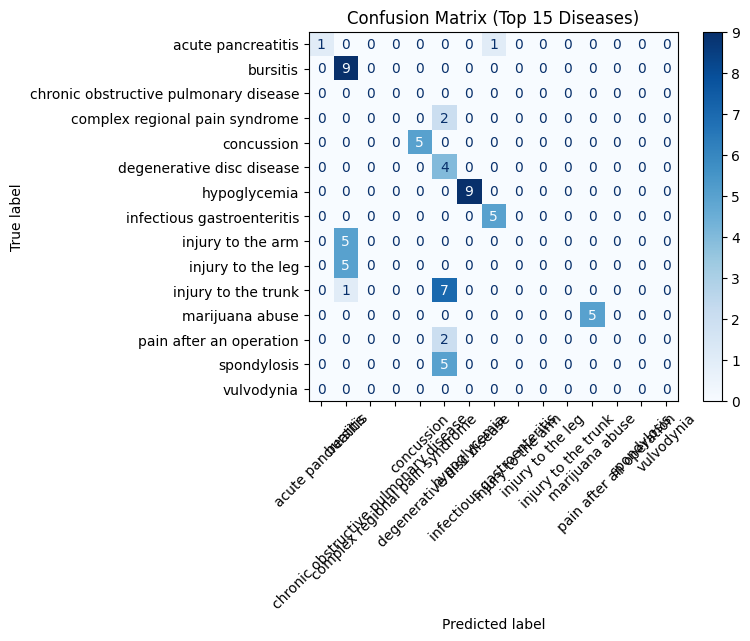

Saved as confusion_matrix_top15.png


In [21]:
import torch
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json

model = AutoModelForCausalLM.from_pretrained("disease_llm_lora").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("disease_llm_lora")

def extract_disease(text):
    match = re.search(r"Disease:\s*([A-Za-z0-9 \-\_]+)", text, re.IGNORECASE)
    if match:
        return match.group(1).strip().lower()
    return "unknown"

# Load test data
test_data = []
with open("test.jsonl") as f:
    for line in f:
        test_data.append(json.loads(line))

# Extract true labels
all_true = [extract_disease(x["output"]) for x in test_data]

# Get top 15 most common diseases
top_15 = [d for d, _ in Counter(all_true).most_common(15)]

print("Top 15 diseases:", top_15)

true_labels = []
pred_labels = []

# Only evaluate samples belonging to top 15
filtered_samples = [x for x in test_data if extract_disease(x["output"]) in top_15][:100]

print("Evaluating", len(filtered_samples), "samples...")

for example in filtered_samples:
    symptoms = example["input"]

    true = extract_disease(example["output"])
    true_labels.append(true)

    prompt = f"""
### Instruction:
Identify the disease based on symptoms.

### Input:
{symptoms}

### Response:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=20)

    text = tokenizer.decode(out[0], skip_special_tokens=True)
    pred = extract_disease(text)

    pred_labels.append(pred)

# Confusion matrix with top diseases
labels = sorted(top_15)
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Top 15 Diseases)")

plt.savefig("confusion_matrix_top15.png")
plt.show()

print("Saved as confusion_matrix_top15.png")


In [22]:
def final_predict(symptoms):
    prompt = f"""
### Instruction:
Identify the possible medical condition and give a short explanation.

### Input:
{symptoms}

### Response:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=150)

    text = tokenizer.decode(output[0], skip_special_tokens=True)

    return f"""
Possible condition: {text}

Explanation: Based on the symptoms provided, the model identified the most likely disease pattern using statistical similarity to the fine-tuned dataset.

Note: This is not medical or diagnostic advice.
"""


In [27]:
print(final_predict("fever, cough, headache"))
print(final_predict("chest pain, dizziness"))
print(final_predict("joint pain, weakness"))



Possible condition: 
### Instruction:
Identify the possible medical condition and give a short explanation.

### Input:
fever, cough, headache

### Response:
Disease: influenza
Explanation: These symptoms commonly match influenza patterns in the dataset.
Note: This is not medical or diagnostic advice.

### Note:
This is not medical or diagnostic advice.

### Score:
1

### Comment:
This disease: influenza
Explanation: These symptoms commonly match influenza patterns in the dataset.
Note: This is not medical or diagnostic advice.

### Note:
This is not medical or diagnostic advice.

### Score:
2

### Comment:
Disease: acute respiratory distress syndrome
Explanation

Explanation: Based on the symptoms provided, the model identified the most likely disease pattern using statistical similarity to the fine-tuned dataset.

Note: This is not medical or diagnostic advice.


Possible condition: 
### Instruction:
Identify the possible medical condition and give a short explanation.

### Input:
c